In [257]:
import numpy as np
import pandas as pd
from numba import njit
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
plt.rcParams["figure.figsize"] = (15, 10)

Lista 3 - PRP41
------

Leonardo Antonio Lugarini

-----------------------------------------

<h3>
Questão 1:
<h3>

In [258]:
V = 5/1000 #m3
P0 = 60*100000#Pa
dot_m = 10#kg/s
k_m = 1.5
gamma = 1.2

T0 = 3000 #K
MolarMass = 22/1000 #kg/mol
R = (8.314462618/MolarMass) #J/(kg K)
rho_oxi = 1144 #kg/m3
rho_fuel = 790 #kg/m3

In [259]:
#a)

def Vandenkerckhove(gamma):
    return np.sqrt(gamma*((2/(gamma + 1))**((gamma + 1)/(gamma - 1))))

def At_c_star_from_P0_gamma_R_T0_dot_m(P0, gamma, R, T0, m):
    At = (np.sqrt(R*T0)*m)/(Vandenkerckhove(gamma)*P0)
    c_star = P0*At/m
    return At, c_star

At, c_star = At_c_star_from_P0_gamma_R_T0_dot_m(P0, gamma, R, T0, dot_m)
print(f"A_t = {At:.6f} m2 e c* = {c_star:.2f} m/s")

A_t = 0.002736 m2 e c* = 1641.86 m/s


b)  Isolaremos os coeficientes $(\mu F)_O$ e $(\mu F)_F$:
$$
m_O (t) = (\mu F)_O \sqrt{2 \rho_O (p_{inj, O}(t) - p_k (t))} \\
m_F (t) = (\mu F)_F \sqrt{2 \rho_F (p_{inj, F}(t) - p_k (t))}

$$

$$
(\mu F)_O = \frac{m_O (t) }{\sqrt{2 \rho_O (p_{inj, O}(t) - p_k (t))}}  \\
(\mu F)_F = \frac{m_F (t) }{\sqrt{2 \rho_F (p_{inj, F}(t) - p_k (t))}}

$$

Descobrir os valores de vazão de oxidante e combustível:

$$
k_m = \frac{m_O}{m_F} \\ \dot{m} = m_O + m_F
$$

Assim,
$$
m_O = \frac{\dot{m}}{1 + \frac{1}{k_m}} \\
m_F = \dot{m} - m_O
$$

Calculando:


In [260]:
def get_coefficients_from_k_m_dot_m_rho_p_inj_pk(km, dot_m, rho_O, rho_F, p_i_O, p_i_F, pk):

    dot_m_O = dot_m/(1 + (1/km))
    dot_m_F = dot_m_O/km

    muF_O = dot_m_O / np.sqrt(2 * rho_O * (p_i_O - pk))
    muF_F = dot_m_F / np.sqrt(2 * rho_F * (p_i_F - pk))

    return muF_O, muF_F

p_inj_O = 65 *100000 #Pa
p_inj_F = 63 *100000 #Pa

muF_O, muF_F = get_coefficients_from_k_m_dot_m_rho_p_inj_pk(k_m, dot_m, rho_oxi, rho_fuel, p_inj_O, p_inj_F, P0)

print(f"Coeficiente de Vazão do Oxidante é {muF_O:.6f}")
print(f"Coeficiente de Vazão do Combustível é {muF_F:.6f}")

Coeficiente de Vazão do Oxidante é 0.000177
Coeficiente de Vazão do Combustível é 0.000184


In [261]:
#c)
@njit
def m_dot_OF(coefficient, rho, p_inj, pk):
    return coefficient*np.sqrt(2*rho*(p_inj - pk))
@njit
def m_dot_G(pk, At, c_star):
    return pk*(At/c_star)

new_p_inj_O = p_inj_O + 6360 #Pa
new_p_inj_F = p_inj_F + 6000 #Pa

pk_vec = np.linspace(P0, min((new_p_inj_F, new_p_inj_O)), 10**7)

m_vec_O = m_dot_OF(muF_O, rho_oxi,new_p_inj_O, pk_vec)
m_vec_F = m_dot_OF(muF_F, rho_fuel,new_p_inj_F, pk_vec)

m_vec_G = m_dot_G(pk_vec, At, c_star)

d_dt_pk_vec = m_vec_O + m_vec_F - m_vec_G

threshold = 1e-4
index_zero = np.where((d_dt_pk_vec >= 0) & (d_dt_pk_vec <= threshold))[0][1]

print(f"Pressão de alimentação do equilibrio é {pk_vec[index_zero]:.3f} Pa")
print(f"Vazão do Oxidante é {m_vec_O[index_zero]:.5f} kg/s")
print(f"Vazão do Combustível é {m_vec_F[index_zero]:.5f} kg/s")

Pressão de alimentação do equilibrio é 6005445.791 Pa
Vazão do Oxidante é 6.00548 kg/s
Vazão do Combustível é 4.00369 kg/s


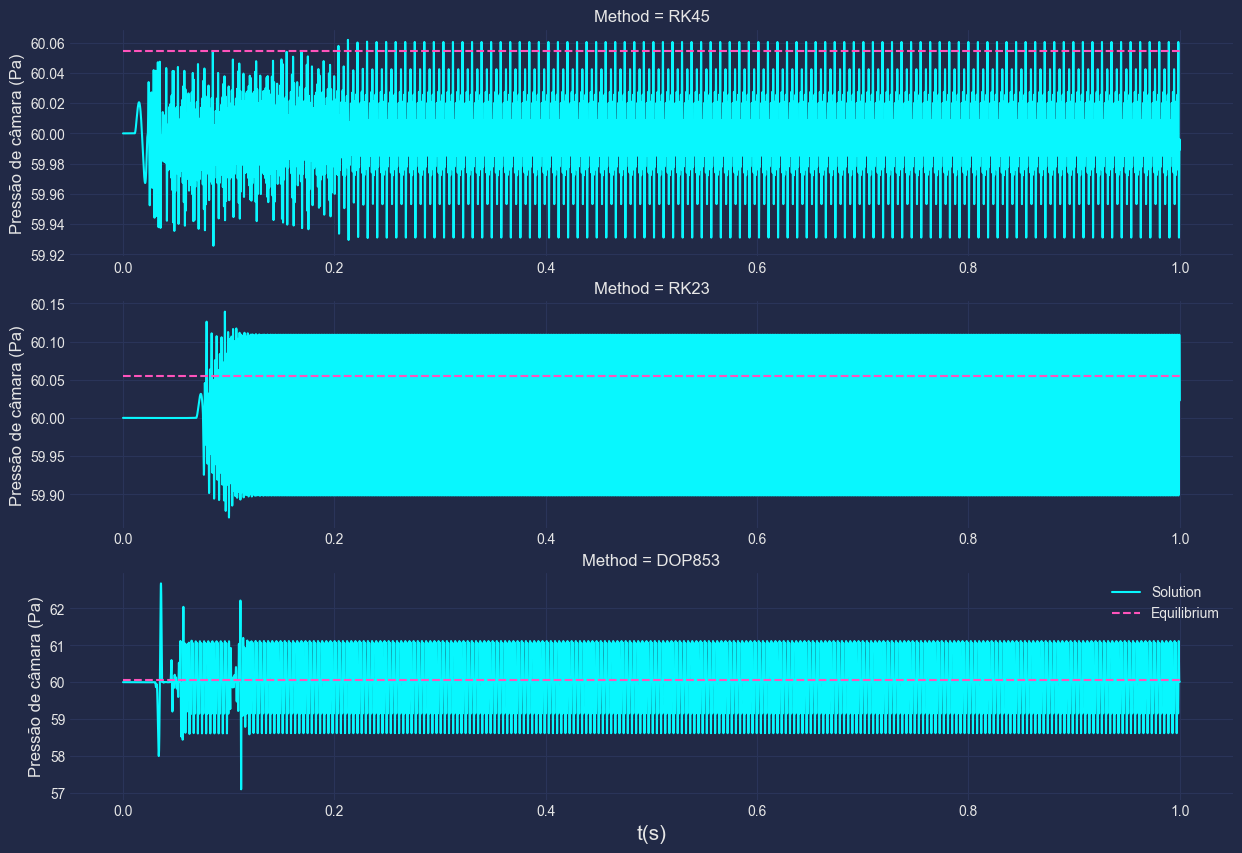

In [262]:
#d)
from scipy.integrate import solve_ivp

def p_inj_O_t(time):
    if time <= 0.1:
        return 65*1e5
    else:
        return 65.00636*1e5
    
def p_inj_F_t(time):
    if time <= 0.1:
        return 63*1e5
    else:
        return 63.006*1e5
    
delay = 1e-3 #s
tstep = 1e-6 #s
t_vec = np.arange(0.0, 1.0, tstep)

def dp_dt(t, p_k):
    if t <= delay:
        delta_t = 0
    else: delta_t = t - delay
    m_O = m_dot_OF(muF_O, rho_oxi,p_inj_O_t(delta_t), p_k)
    m_F = m_dot_OF(muF_F, rho_fuel,p_inj_F_t(delta_t), p_k)
    m_G = m_dot_G(p_k, At, c_star)
    return (R*T0/V)*(m_O + m_F - m_G)

methods = ["RK45", "RK23", "DOP853"]

plt.rcParams["figure.figsize"] = (15, 10)
fig, axs = plt.subplots(len(methods), 1)

for i, method in enumerate(methods):
    sol = solve_ivp(dp_dt, t_span=[0, 1], y0 = np.array([P0]), method=method,t_eval=t_vec)
    axs[i].plot(sol.t, sol.y[0]/1e5)
    axs[i].set(title = f"Method = {method}")
    axs[i].plot([0,1], [pk_vec[index_zero]/1e5, pk_vec[index_zero]/1e5], linestyle = "dashed")
    axs[i].set_ylabel('Pressão de câmara (Pa)',fontsize=12)
    plt.xlabel('t(s)',fontsize=15)
    plt.legend(["Solution", "Equilibrium"])


In [263]:
#e)

p_inj_O = 75 *100000 #Pa
p_inj_F = 73 *100000 #Pa

muF_O, muF_F = get_coefficients_from_k_m_dot_m_rho_p_inj_pk(k_m, dot_m, rho_oxi, rho_fuel, p_inj_O, p_inj_F, P0)

print(f"Coeficiente de Vazão do Oxidante é {muF_O:.6f}")
print(f"Coeficiente de Vazão do Combustível é {muF_F:.6f}")

Coeficiente de Vazão do Oxidante é 0.000102
Coeficiente de Vazão do Combustível é 0.000088


In [264]:
#f)

new_p_inj_O = p_inj_O + 10.48*1e5 #Pa
new_p_inj_F = p_inj_F + 10*1e5 #Pa

pk_vec = np.linspace(P0, min((new_p_inj_F, new_p_inj_O)), 10**7)

m_vec_O = m_dot_OF(muF_O, rho_oxi,new_p_inj_O, pk_vec)
m_vec_F = m_dot_OF(muF_F, rho_fuel,new_p_inj_F, pk_vec)

m_vec_G = m_dot_G(pk_vec, At, c_star)

d_dt_pk_vec = m_vec_O + m_vec_F - m_vec_G

threshold = 1e-6
index_zero = np.where((d_dt_pk_vec >= 0) & (d_dt_pk_vec <= threshold))[0][0]

print(f"Pressão de alimentação do equilibrio é {pk_vec[index_zero]:.3f} Pa")
print(f"Vazão do Oxidante é {m_vec_O[index_zero]:.5f} kg/s")
print(f"Vazão do Combustível é {m_vec_F[index_zero]:.5f} kg/s")

Pressão de alimentação do equilibrio é 6685700.219 Pa
Vazão do Oxidante é 6.68545 kg/s
Vazão do Combustível é 4.45739 kg/s


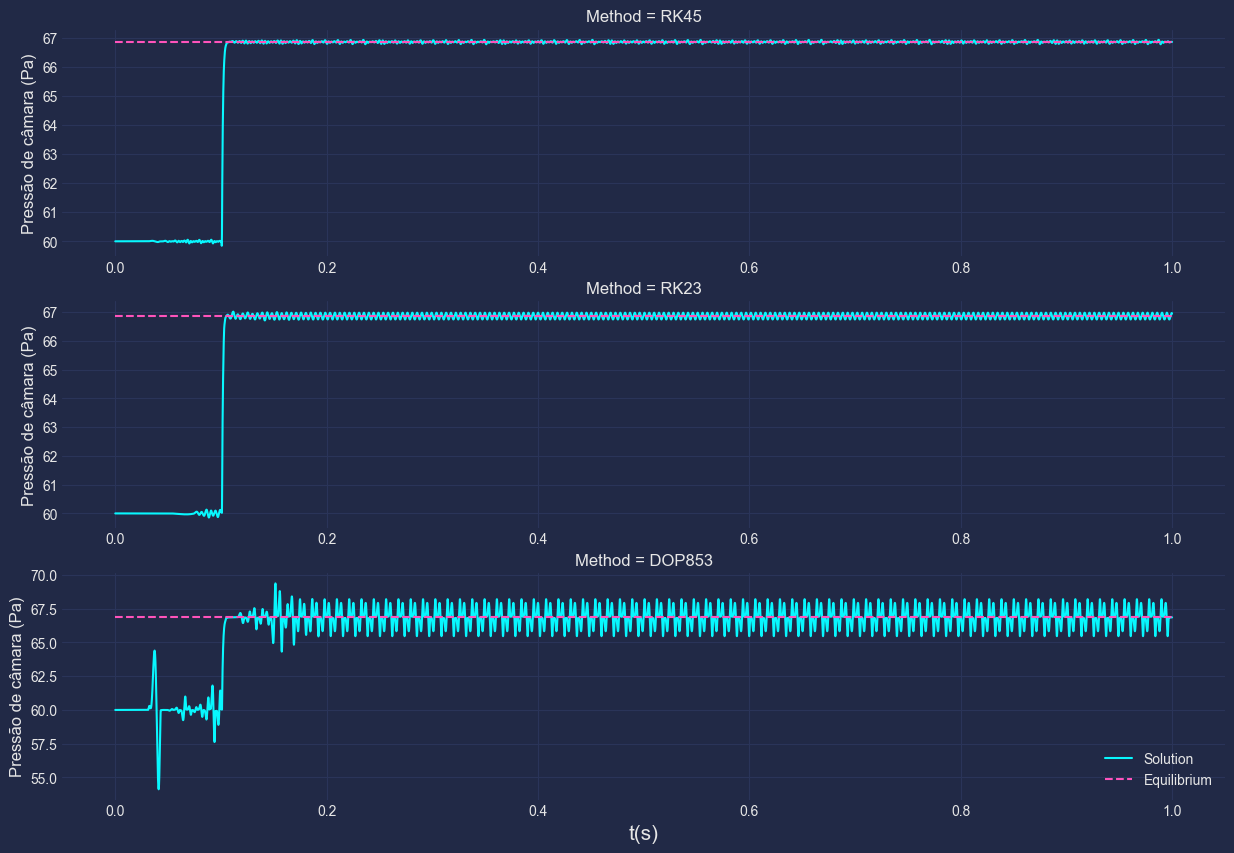

In [265]:
#g)

def p_inj_O_t(time):
    if time <= 0.1:
        return 75*1e5
    else:
        return 85.48*1e5
    
def p_inj_F_t(time):
    if time <= 0.1:
        return 73*1e5
    else:
        return 83*1e5
    
delay = 1e-3 #s
tstep = 1e-6 #s
t_vec = np.arange(0.0, 1.0, tstep)

def dp_dt(t, p_k):
    if t <= delay:
        delta_t = 0
    else: delta_t = t - delay
    m_O = m_dot_OF(muF_O, rho_oxi,p_inj_O_t(delta_t), p_k)
    m_F = m_dot_OF(muF_F, rho_fuel,p_inj_F_t(delta_t), p_k)
    m_G = m_dot_G(p_k, At, c_star)
    return (R*T0/V)*(m_O + m_F - m_G)

plt.rcParams["figure.figsize"] = (15, 10)

fig, axs = plt.subplots(len(methods), 1)

for i, method in enumerate(methods):
    sol = solve_ivp(dp_dt, t_span=[0, 1], y0 = np.array([P0]), method=method,t_eval=t_vec)
    axs[i].plot(sol.t, sol.y[0]/1e5)
    axs[i].set(title = f"Method = {method}")
    axs[i].plot([0,1], [pk_vec[index_zero]/1e5, pk_vec[index_zero]/1e5], linestyle = "dashed")
    axs[i].set_ylabel('Pressão de câmara (Pa)',fontsize=12)
    plt.xlabel('t(s)',fontsize=15)
    plt.legend(["Solution", "Equilibrium"])

h) A perda de carga nos injetores de um Motor de Foguete de Propulsão Líquida é essencial para o desempenho e a segurança do motor. <br>Ela regula o fluxo de combustível e oxidante, garantindo uma entrega controlada e estável dos propulsores à câmara de combustão. <br>Além disso, a perda de carga é crucial para a atomização eficiente dos propulsores, facilitando uma mistura homogênea e uma combustão completa,<br> o que é vital para a eficiência do motor. Também desempenha um papel na prevenção do retrocesso de chamas, mantendo a operação segura.<br> O design adequado da perda de carga nos injetores é fundamental para evitar oscilações de pressão e garantir a estabilidade do motor, <br>impactando diretamente no seu desempenho global. Assim, uma perda de carga bem calculada e implementada é um componente chave para <br>otimizar a eficiência, confiabilidade e segurança em motores de foguetes.







<h3>
Questão 2:
<h3>

In [266]:
from scipy.optimize import root

RHO = 667 #kg/m3
NI = 2.8657*1e-7 #m^2/s
N = 4#furos tangenciais
DELTA_M = 45*1e-3 #kg/s
ESPESSURA = 2*1e-3 #m

def analise_injetor_centrifugo_etanol(
        r_in = 0.4*1e-3, 
        r_c = 3*1e-3, 
        R_k = 3*1e-3, 
        R_in = 2.5*1e-3, 
        RHO = 667, 
        NI = 2.8657*1e-7, 
        N_FUROS = 4, 
        DELTA_M = 45*1e-3, 
        ESPESSURA = 2*1e-3
    ):
    
    A = (R_in*r_c)/(N_FUROS*(r_in**2))
    C = R_in/r_c

    eps_in = 1.1 - (6/(5*np.pi))*np.arccos(R_in/(R_k + ESPESSURA))

    v_in = DELTA_M/(N_FUROS*RHO*np.pi*(r_in**2))
    Re_in = (2*r_in)*v_in/NI
    Lambda = 0.3164*(Re_in)**(-0.25) 
    L_in = np.sqrt(R_in**2 + (R_k + ESPESSURA)**2)
    eps_ch = Lambda*(L_in/(2*r_in))

    eps_inj = eps_in + eps_ch

    if R_in >= r_c:
        Aeq = (R_in*r_c)/(N_FUROS*r_in**2 + 0.5*Lambda*R_in*(R_in - r_c))
    else:
        Aeq = A

    def Aeq_function(phi_eq):
        return Aeq - (1 - phi_eq)*np.sqrt(2)/(phi_eq*np.sqrt(phi_eq))
    sol = root(Aeq_function, 0.2)
    Phi_eq = sol.x[0]

    mu = 1/np.sqrt((1/Phi_eq**2) + (Aeq**2/(1 - Phi_eq)) + eps_inj*(A**2/C**2))

    delta_p_inj = (DELTA_M/(mu*np.pi*r_c**2))**2/(2*RHO)

    alpha_m = np.arcsin(2*mu*Aeq/((1 + np.sqrt(1 - Phi_eq))*np.sqrt(1 - eps_inj*mu**2*(A**2/C**2))))

    return Phi_eq, delta_p_inj, 2*alpha_m*180/np.pi

In [267]:
#DADOS PONTO BASE
# r_in = 0.4*1e-3 m
# r_c = 3*1e-3 m
# R_k = 3*1e-3 m
# R_in = 2.5*1e-3 m

input_params = {
    "a)": "Pontos Base",
    "b)": "r_c = 2*1e-3",
    "c)": "r_c = 2.5*1e-3",
    "d)": "r_in = 0.3*1e-3",
    "e)": "r_in = 0.5*1e-3",
    "f)": "R_k = 3.5*1e-3",
    "g)": "R_k = 4*1e-3",
    "h)": "R_in = 2*1e-3",
    "i)": "R_in = 2.9*1e-3"
}

tabela_resultados = pd.DataFrame(
    [analise_injetor_centrifugo_etanol()], 
    columns = [
        "Fator de Preenchimento", 
        "Queda de pressão do injetor (Pa)", 
        "Ângulo de saída ( °)"
    ], 
    index = ["a)"]
)
tabela_resultados.loc["b)"] = analise_injetor_centrifugo_etanol(r_c = 2*1e-3)
tabela_resultados.loc["c)"] = analise_injetor_centrifugo_etanol(r_c = 2.5*1e-3)
tabela_resultados.loc["d)"] = analise_injetor_centrifugo_etanol(r_in = 0.3*1e-3)
tabela_resultados.loc["e)"] = analise_injetor_centrifugo_etanol(r_in = 0.5*1e-3)
tabela_resultados.loc["f)"] = analise_injetor_centrifugo_etanol(R_k = 3.5*1e-3)
tabela_resultados.loc["g)"] = analise_injetor_centrifugo_etanol(R_k = 4*1e-3)
tabela_resultados.loc["h)"] = analise_injetor_centrifugo_etanol(R_in = 2*1e-3)
tabela_resultados.loc["i)"] = analise_injetor_centrifugo_etanol(R_in = 2.9*1e-3)
tabela_resultados["Mudança nas Váriaveis"] = tabela_resultados.index.map(input_params)
tabela_resultados

,Fator de Preenchimento,Queda de pressão do injetor (Pa),Ângulo de saída ( °),Mudança nas Váriaveis
a),0.208888,6.834376e+05,124.474967,Pontos Base
b),0.263935,1.217970e+06,116.520126,r_c = 2*1e-3
c),0.231391,8.723874e+05,121.159776,r_c = 2.5*1e-3
d),0.149391,2.070797e+06,133.859677,r_in = 0.3*1e-3
e),0.267261,2.964553e+05,116.054457,r_in = 0.5*1e-3
f),0.208888,6.798485e+05,124.474967,R_k = 3.5*1e-3
g),0.208888,6.777040e+05,124.474967,R_k = 4*1e-3
h),0.236682,5.450203e+05,120.394058,R_in = 2*1e-3
i),0.191907,8.113320e+05,127.049500,R_in = 2.9*1e-3


Na análise das variáveis que influenciam as grandezas de saída em um sistema de injeção, <br>observa-se que o raio crítico (r_c) e o raio interno (r_in) são particularmente relevantes.<br> O r_c demonstra ser uma variável chave para o Fator de Preenchimento, <br> com mudanças significativas observadas quando ele varia.Por outro lado, <br> o r_in é crucial tanto para a Queda de Pressão do Injetor quanto para o Ângulo de Saída, <br> com alterações em seu valor resultando em variações notáveis nessas grandezas. <br> As outras variáveis, como o raio de Kruger (R_k) e o raio interno (R_in), também afetam as grandezas de saída,<br>  mas em menor grau, indicando que r_c e r_in<br>  são os fatores mais influentes no comportamento do sistema de injeção analisado.